In [1]:
import sys
sys.path.insert(0, '/Users/mattlowery/Desktop/Desko/code/astro/hetvae/src/')

In [2]:
import utils 
import numpy as np
import torch
import matplotlib.pyplot as plt

/opt/homebrew/Caskroom/miniforge/base/envs/hetvae/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


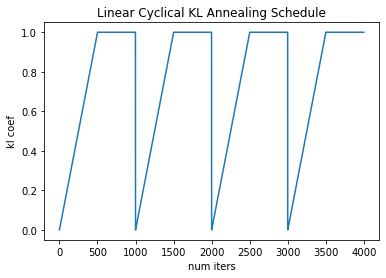

In [4]:
plt.plot(utils.frange_cycle_linear(4000, start=0.0, stop=1.0,  n_cycle=4, ratio=0.5))
plt.title('Linear Cyclical KL Annealing Schedule')
plt.xlabel('num iters')
plt.ylabel('kl coef')
plt.savefig('kl_sched')

In [103]:
lcs = utils.get_data('../datasets/ZTF_gr', sep=',', start_col=1, batch_size=4, min_length=40, n_union_tp=1000, num_resamples=0)
net, optimizer, args, epoch, loss = utils.load_checkpoint('./h5_2/ZTFgr_small0.915856122970581.h5', lcs.data_obj)

validated 3398 files out of 3398 for band='r'
validated 3399 files out of 3399 for band='g'
3398 3398
created union_tp attribute of length 1000
dataset created w/ shape (2285, 2, 3985, 3)
train size: 685, valid size: 480, test size: 1600
=> loading checkpoint './h5_2/ZTFgr_small0.915856122970581.h5'
Namespace(n_union_tp=1000, data_folder='datasets/ZTFgr_small', checkpoint='', start_col=1, inc_errors=False, print_at=1, embed_time=128, enc_num_heads=16, latent_dim=64, mixing='concat', num_ref_points=16, rec_hidden=128, width=512, save_at=100, patience=100, early_stopping=False, niters=3000, frac=0.5, batch_size=64, mse_weight=5.0, dropout=0.0, num_resamples=0, lr=0.0003, scheduler=False, warmup=4000, kl_zero=False, kl_annealing=True, net='hetvae', device='mps', const_var=False, var_per_dim=False, std=0.1, seed=0, save=True, k_iwae=1)


In [21]:
lcs = utils.get_data('../datasets/ZTF_gband', sep=',', start_col=1, batch_size=4, min_length=40, n_union_tp=1000, num_resamples=0)
net, optimizer, args, epoch, loss = utils.load_checkpoint('./h5_2/0.9198.h5', lcs.data_obj)

validated 3399 files out of 3399 for band='g'
3399 3399
created union_tp attribute of length 1000
dataset created w/ shape (2324, 1, 1974, 3)
train size: 697, valid size: 488, test size: 1627
=> loading checkpoint './h5_2/0.9198.h5'
Namespace(n_union_tp=1000, data_folder='datasets/ZTF_gband', checkpoint='0.9405.h5', start_col=1, inc_errors=False, print_at=1, embed_time=128, enc_num_heads=16, latent_dim=64, mixing='concat', num_ref_points=16, rec_hidden=128, width=512, save_at=100, patience=100, early_stopping=False, niters=3000, frac=0.5, batch_size=256, mse_weight=5.0, dropout=0.0, lr=0.0003, scheduler=False, warmup=4000, kl_zero=False, kl_annealing=True, net='hetvae', device='mps', const_var=False, var_per_dim=False, std=0.1, seed=0, save=True, k_iwae=1)


In [104]:
print(loss)

3.141350662679695


In [105]:
lcs.set_target_x(n=100)

(4, 3985, 2)
(4, 3985, 2)


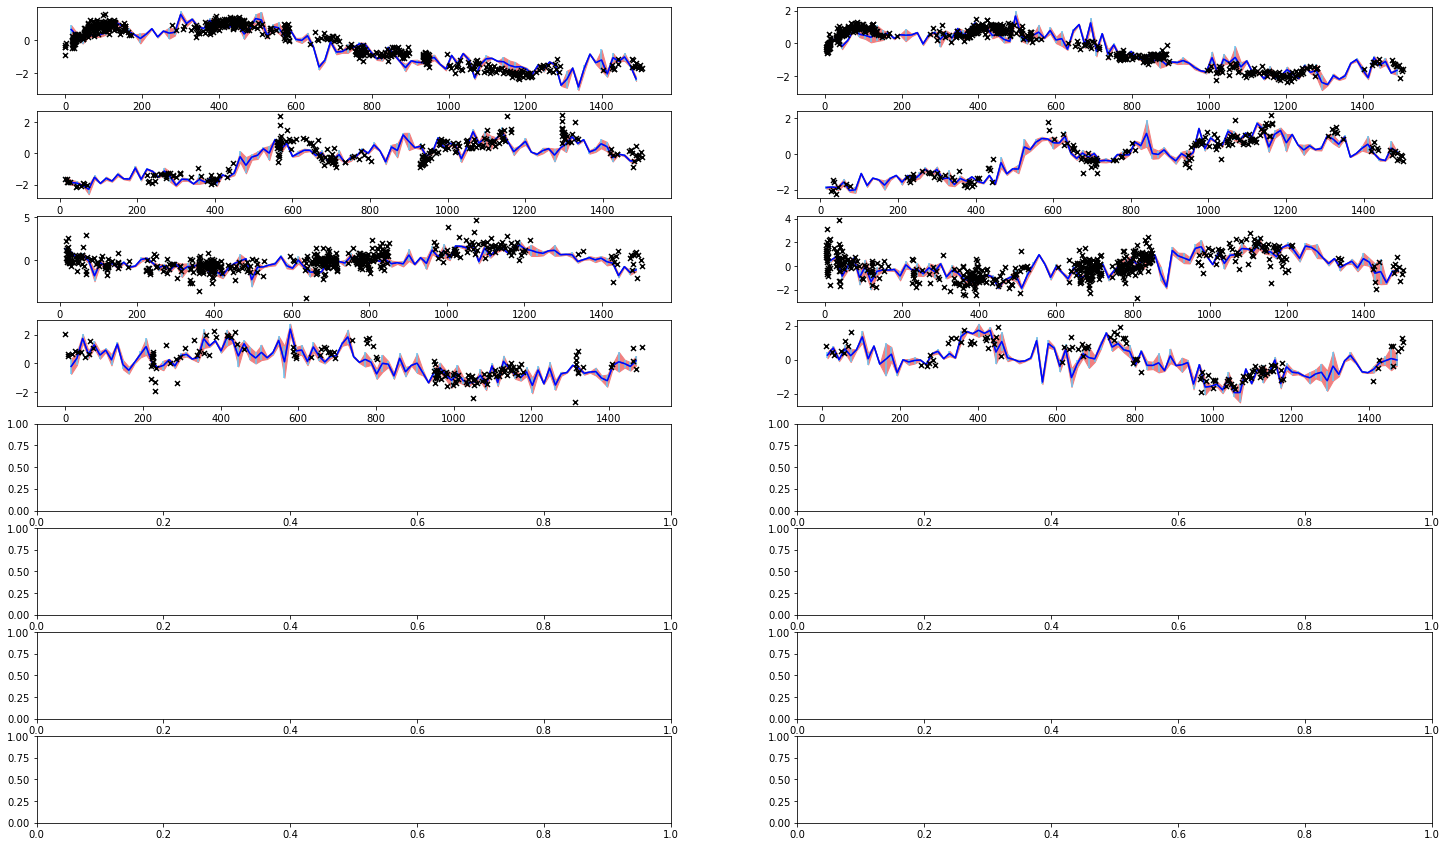

In [112]:
def predict(dataloader, net, device='mps', k_iwae=2, subsample=False, target_x=None, plot=True, figsize=(25,15)):
    pred_mean, pred_std = [], []
    qz_mean, qz_std = [], []
    masks = []
    targets = []
    tp =[]
    target_tp = []
    np.random.seed(0)
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            batch_len = batch.shape[0]
            
            if subsample == True:
                subsampled_mask = utils.make_masks(batch, frac=0.5)
            else:
                subsampled_mask = utils.make_masks(batch, frac=1.0)
                
            batch = batch.to(device)
            subsampled_mask = subsampled_mask.to(device)
            recon_mask = torch.logical_xor(batch[:,:,:,1], subsampled_mask)
            context_y = torch.cat((batch[:,:,:,1] * subsampled_mask, subsampled_mask), 1).transpose(2,1)
            recon_context_y=torch.cat((batch[:,:,:,1] * recon_mask, recon_mask), 1).transpose(2,1)
            if target_x is not None:
                tx = torch.tensor(target_x[i*batch_len:(i*batch_len + batch_len)])[:,0]
            else:
                tx = batch[:, 0, :,0]

            px, qz = net.get_reconstruction(batch[:, 0, :,0], context_y, tx, num_samples=k_iwae)
            pred_mean.append(px.mean.cpu().numpy())
            pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
            qz_mean.append(qz.mean.cpu().numpy())
            qz_std.append(torch.exp(0.5 * qz.logvar).cpu().numpy())
            targets.append((batch[:, :, :,1]).cpu().numpy())
            masks.append(subsampled_mask.cpu().numpy())
            tp.append(batch[:, 0, :,0].cpu().numpy())
            target_tp.append(tx.cpu().numpy())
            if i == 0:
                break
            
    # reconstructions
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    # latent space 
    qz_mean = np.concatenate(qz_mean, axis=0)
    qz_std = np.concatenate(qz_std, axis=0)
    
    # targets are all ys, masks are masks, inputs are masked ys
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    inputs = np.ma.masked_where(masks < 1., targets)
    inputs = np.transpose(inputs, [0,2,1])
    targets = np.transpose(targets, [0,2,1])
    
    # target tp are points we'd like to project to
    tp = np.concatenate(tp, axis=0)
    target_tp = np.concatenate(target_tp, axis=0)
    
    # reparam trick to sample from predictions
    preds = np.random.randn(k_iwae//2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    median = preds.mean(0)
    
    # sample from latent space dist 
    qz_preds = np.random.randn(k_iwae//2, k_iwae, qz_mean.shape[0], qz_mean.shape[1], qz_mean.shape[2]) * qz_std + qz_mean
    qz_preds = qz_preds.reshape(-1, qz_mean.shape[0], qz_mean.shape[1], qz_mean.shape[2])
    qz_median = qz_preds.mean(0)
    
    quantile2 = np.quantile(preds, 0.841, axis=0)
    quantile1 = np.quantile(preds, 0.159, axis=0)
    print(inputs.shape)
    print(quantile2.shape)
    
    if plot == True:
        
        fig,ax = plt.subplots(8,2,figsize=figsize)
        
        for ex in range(4):
            pred_t = target_tp[ex].nonzero()[0]
            input_t = tp[ex].nonzero()[0]
            for band in range(2):
                std = (quantile2[ex,pred_t,band] - median[ex,pred_t,band])
                # preds plotting
                ax[ex,band].plot(target_tp[ex, pred_t],median[ex,pred_t,band])
                ax[ex,band].fill_between(target_tp[ex,pred_t],median[ex,pred_t,band]-std , median[ex,pred_t,band]+std, label='error envelope',color='lightcoral')
                ax[ex,band].errorbar(target_tp[ex,pred_t], median[ex,pred_t,band], yerr=(median[ex,pred_t,band]+std), c='blue', ecolor='#65c9f7', label='prediction')
                
                # inputs the preds are conditioned on
                ax[ex,band].scatter(tp[ex,input_t], inputs[ex,input_t,band], c='black', marker='x', zorder=30, label='conditioned on', s=25)
                
 
    return qz_preds, tp, targets, inputs, target_tp, preds

qz_preds, tp, targets, inputs, target_tp, preds = predict(lcs.data_obj['train_loader'], net, target_x=lcs.target_x, subsample=False)

In [ ]:
qz_preds.shape

In [ ]:
RS = 20150101
latent = latent.reshape((len(latent), -1))
proj = TSNE(random_state=RS).fit_transform(latent)
plt.scatter(proj[:,0], proj[:,1])

## Compare test loss w/ train loss

In [114]:
train = lcs.data_obj['train_loader']
test = lcs.data_obj['test_loader']

test_nll, mse = utils.evaluate_hetvae(
                net,
                2,
                test,
                0.5,
                k_iwae=1,
                device='mps'
                )

print(test_nll, mse)

KeyboardInterrupt: 

## ALIGN OBJECTS for RM

In [69]:
from dataset import DataSet
import os
import utils

In [245]:
%autoreload

In [253]:
lcs = utils.get_data('../datasets/ztf_gr', sep=',', start_col=1)

validated 3398 files out of 3398 for band='r'
validated 3399 files out of 3399 for band='g'
3398 3398
created union_tp attribute of length 3500
dataset created w/ shape (2285, 2, 3985, 3)
train size: 1828, valid size: 366, test size: 457


In [214]:
lcs.valid_files_df

,r,g
001822.06+064750.2,../datasets/ztf_gr/r/001822.06+064750.2_DR_rba...,../datasets/ztf_gr/g/001822.06+064750.2_DR_gba...
003841.53+000226.6,../datasets/ztf_gr/r/003841.53+000226.6_DR_rba...,../datasets/ztf_gr/g/003841.53+000226.6_DR_gba...
130118.19+283453.1,../datasets/ztf_gr/r/130118.19+283453.1_DR_rba...,../datasets/ztf_gr/g/130118.19+283453.1_DR_gba...
113820.11+363404.5,../datasets/ztf_gr/r/113820.11+363404.5_DR_rba...,../datasets/ztf_gr/g/113820.11+363404.5_DR_gba...
081036.29+172023.1,../datasets/ztf_gr/r/081036.29+172023.1_DR_rba...,../datasets/ztf_gr/g/081036.29+172023.1_DR_gba...
...,...,...
093438.57+405629.8,../datasets/ztf_gr/r/093438.57+405629.8_DR_rba...,../datasets/ztf_gr/g/093438.57+405629.8_DR_gba...
091233.54+151114.0,../datasets/ztf_gr/r/091233.54+151114.0_DR_rba...,../datasets/ztf_gr/g/091233.54+151114.0_DR_gba...
155059.69+142546.5,../datasets/ztf_gr/r/155059.69+142546.5_DR_rba...,../datasets/ztf_gr/g/155059.69+142546.5_DR_gba...
110810.30+155305.9,../datasets/ztf_gr/r/110810.30+155305.9_DR_rba...,../datasets/ztf_gr/g/110810.30+155305.9_DR_gba...


In [216]:
lcs.dataset.shape

(2285, 2, 3868, 3)

In [247]:
lc = lcs.dataset[0,0,:,:]
lc2 = lcs.dataset[0,1,:,:]

In [248]:
z = lc[lc[:,0].nonzero() and lc[:,1].nonzero()]
z2 = lc2[lc2[:,0].nonzero() and lc2[:,1].nonzero()]

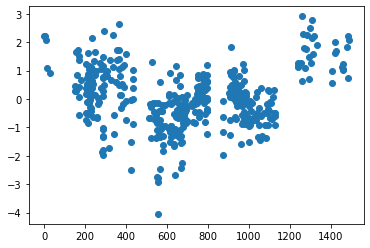

In [249]:
plt.scatter(z[:,0], z[:,1])

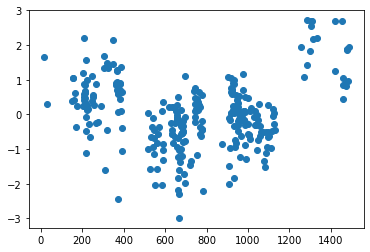

In [250]:
plt.scatter(z2[:,0], z2[:,1])